### Import

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import *
from vvm_var_func import *

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn.colors.xkcd_rgb as c
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Calculation of initial profile

In [2]:
def ccequation(temperature:float):
    es0 = 6.11   # mb
    Rv  = 461
    Lv  = 2.5e6  # J/kg
    T0  = 273    # K
    return es0*np.exp(Lv/Rv*(1/T0-1/temperature))

In [4]:
def theta_to_temp(pressure:float, theta:float):
    Rd = 287
    Cp = 1004
    return theta*(pressure/1000)**(Rd/Cp)

In [16]:
def derive_qvs(pressure:float, temperature:float):
    epsilon = 287/461
    es      = ccequation(temperature)
    return epsilon*(es/pressure)

In [17]:
def derive_qv_from_RH(pressure:float, temperature:float, RH:float):
    qvs     = derive_qvs(pressure, temperature)
    return qvs*RH

#### Calculation of three points

In [18]:
# Surface: 1000hPa, theta=294K
temp_surf = theta_to_temp(pressure=1000, theta=294)
qv_surf   = derive_qv_from_RH(pressure=1000, temperature=temp_surf, RH=0.8)
print(f"Temperature at surface = {temp_surf} K.")
print(f"qv at surface          = {qv_surf*1e3:5.3f} g/kg.")

Temperature at surface = 294.0 K.
qv at surface          = 12.576 g/kg.


In [19]:
# Sounding1: 780hPa, theta=310K
temp_s1 = theta_to_temp(pressure=780, theta=310)
qv_s1   = derive_qv_from_RH(pressure=780, temperature=temp_s1, RH=0.8)
print(f"Temperature at high level of sounding 1 = {temp_s1} K.")
print(f"qv at high level of sounding 1          = {qv_s1*1e3:5.3f} g/kg.")

Temperature at high level of sounding 1 = 288.7461662270175 K.
qv at high level of sounding 1          = 11.526 g/kg.


In [20]:
# Sounding1: 780hPa, theta=316K
temp_s2 = theta_to_temp(pressure=780, theta=316)
qv_s2   = derive_qv_from_RH(pressure=780, temperature=temp_s2, RH=0.8)
print(f"Temperature at high level of sounding 2 = {temp_s2} K.")
print(f"qv at high level of sounding 2          = {qv_s2*1e3:5.3f} g/kg.")

Temperature at high level of sounding 2 = 294.33480170237914 K.
qv at high level of sounding 2          = 16.464 g/kg.


## Simulation Analysis

### Case list

In [25]:
case_name={'cs1':'pbl_mod_wfire_coastal_s1', 
           'cs2':'pbl_mod_wfire_coastal_s2',
           'is1':'pbl_mod_wfire_inland_s1',
           'is2':'pbl_mod_wfire_inland_s2'}

### Load multi-timestep varfiles

In [28]:
ds_dyn_cs1 = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs1"]}/archive/{case_name["cs1"]}.L.Dynamic*')

In [29]:
ds_thm_cs1 = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs1"]}/archive/{case_name["cs1"]}.L.Thermodynamic*')

In [30]:
ds_chem_cs1= xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs1"]}/archive/{case_name["cs1"]}.L.Chemical*')

In [31]:
ds_tra_cs1 = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs1"]}/archive/{case_name["cs1"]}.L.Tracer*')

In [32]:
# Winds
u_cs1, v_cs1, w_cs1 = ds_dyn_cs1.u, ds_dyn_cs1.v, ds_dyn_cs1.w
# Theta
th_cs1 = ds_thm_cs1.th
# Tracer
tr01_cs1, tr02_cs1  = ds_tra_cs1.tr01, ds_tra_cs1.tr02
# NOx
NO_cs1, NO2_cs1     = ds_chem_cs1.NO, ds_chem_cs1.NO2

In [100]:
# Tracer (normalized)
tr02_norm_cs1 = (tr02_cs1-tr02_cs1.max())/(tr02_cs1.max()-tr02_cs1.min())

### PBL boundary

#### Height where theta=theta(lev=0)+0.5K

In [33]:
def find_level(pt, levels):
    # Iterate over levels and find the first level where pt >= pt[lev0] + 0.5
    target_temp = pt[0] + 0.5
    idx = np.argmax(pt >= target_temp, axis=0)
    
    # Set to 0 if no level satisfies the condition
    idx = np.where(np.any(pt >= target_temp, axis=0), idx, 0)
    return levels[idx]

In [34]:
def get_ymean_pblh_theta05(theta:xr.DataArray):
    return xr.apply_ufunc(find_level,
                          theta,
                          theta.lev,
                          input_core_dims=[['lev'], ['lev']],
                          vectorize=True,  # Apply across all other dimensions
                          dask="parallelized",  # Use Dask for larger datasets
                          output_dtypes=[float]  # Output will be float
                         ).mean(dim=['lat'])

In [35]:
th05_cs1 = get_ymean_pblh_theta05(th_cs1)

In [37]:
arr_th05_cs1 = th05_cs1.values

In [38]:
arr_th05_cs1.shape

(258, 128)

#### d_theta/dz max

In [39]:
def get_ymean_pblh_dthdz(theta:xr.DataArray):
    arr_theta = theta.values
    slope     = (arr_theta[:, 1:, ...]-arr_theta[:, :-1, ...])/0.02
    arr_slope_idx = np.argmax(slope, axis=1)
    slope_idx = xr.DataArray(arr_slope_idx, dims=['time', 'lat', 'lon'])
    dthdz_H   = theta.lev.isel(lev=slope_idx).mean(dim=['lat'])
    return dthdz_H

In [40]:
dthdzH_cs1 = get_ymean_pblh_dthdz(th_cs1)

In [41]:
arr_dthdzH_cs1 = dthdzH_cs1.values

In [42]:
arr_dthdzH_cs1.shape

(258, 128)

### Tracer 01 (Single point emmision)

In [79]:
def Plot_tr01_ymean(time:int, case:str, figpath=False):
    # Case data
    th05   = eval(f'arr_th05_{case}')
    dthdzH = eval(f'arr_dthdzH_{case}')
    tr01   = eval(f'tr01_{case}')
    u, w   = eval(f'u_{case}'), eval(f'w_{case}')
    # Figure
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(':', linewidth=0.5)
    x      = np.arange(tr01.lon.shape[0])
    ## Tracer 01
    bounds = np.arange(0, 1.1, 0.1)
    im     = ax.contourf(x, tr01.lev, tr01.isel(time=time).mean(dim='lat'), 
                         levels=bounds, cmap=cmaps.WhiteYellowOrangeRed, extend='max')
    cbar   = fig.colorbar(im, extend='max')
    cbar.set_ticks(ticks=bounds, labels=[f'{i:3.1f}' for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('kg/kg', fontsize=14)
    ## Wind
    ax.quiver(x[::2], tr01.lev[::2], 
              u.isel(time=time).mean(dim='lat')[::2, ::2], 
              w.isel(time=time).mean(dim='lat')[::2, ::2], angles='xy')
    ## Theta+0.5
    ax.plot(x, th05[time, :], 'k', linewidth=3, label=r'$\theta$(z=0) +0.5K')
    ## max. theta variability
    ax.plot(x, dthdzH[time, :], color='grey', linewidth=3, label=r'd$\theta$/dz max.')
    # Info settings
    ax.text(x=x[20], y=-0.22, s='Ocean', color=c['deep sea blue'], fontsize=16, fontweight='bold')
    ax.text(x=x[86], y=-0.22, s='Forest', color=c['sap green'], fontsize=16, fontweight='bold')
    ax.set_xticks(np.arange(0, x.shape[0]+0.1, 32))
    ax.set_xticklabels([f'{i:4.2f}' for i in np.arange(0, 2.561, 0.64)], fontsize=13)
    ax.set_xlabel('x (km)', fontsize=14)
    ax.set_yticks(np.arange(0, 1.9, 0.25))
    ax.set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax.set_ylabel('Height (km)', fontsize=14)
    ax.legend(loc='upper right', fontsize=14)
    ax.set_title('Tracer 01', fontsize=16)
    ax.set_title('y-mean', loc='right', fontsize=12)
    ax.set_title(f'Time = {(datetime(2024, 1, 1, 5)+timedelta(seconds=120*time)).strftime("%H:%M:%S")}', 
                 loc='left', fontsize=12)
    if figpath:
        plt.savefig(f'./Figure/{figpath}/tr01_ts_{time:03d}.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

/data/mlcloud/miniconda3/envs/weiting3.7/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/data/mlcloud/miniconda3/envs/weiting3.7/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


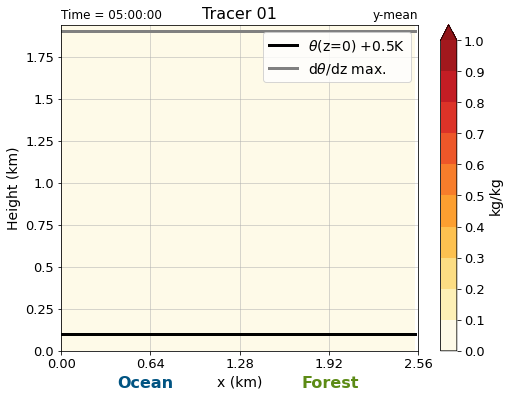

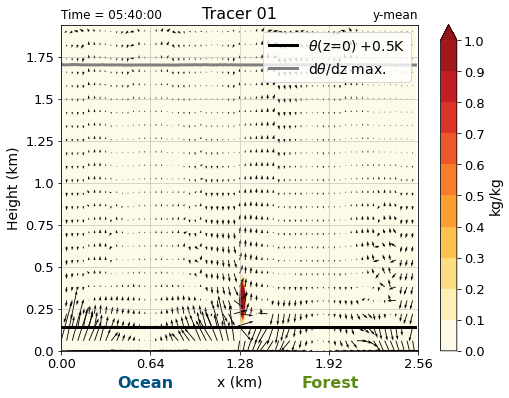

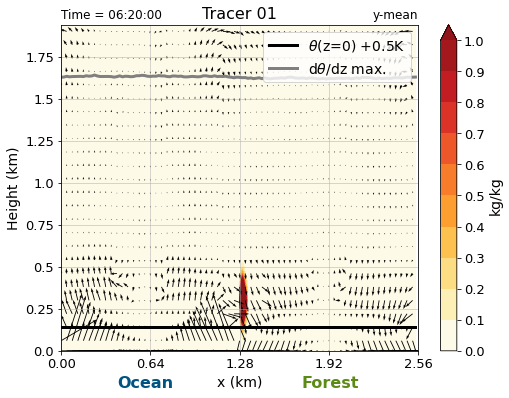

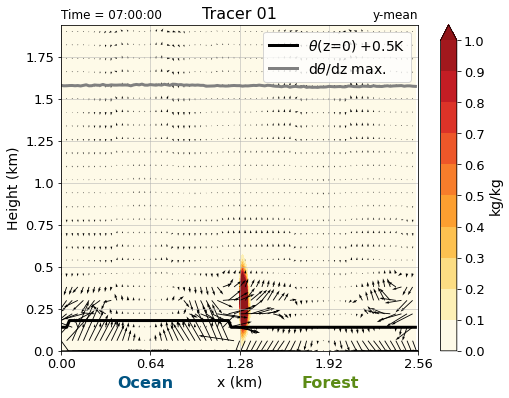

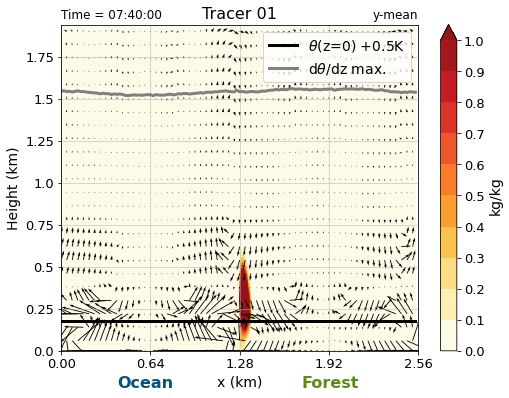

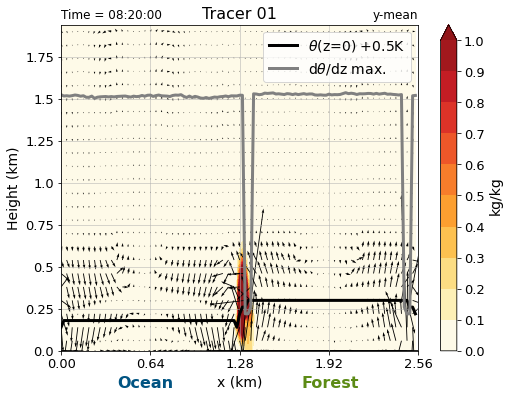

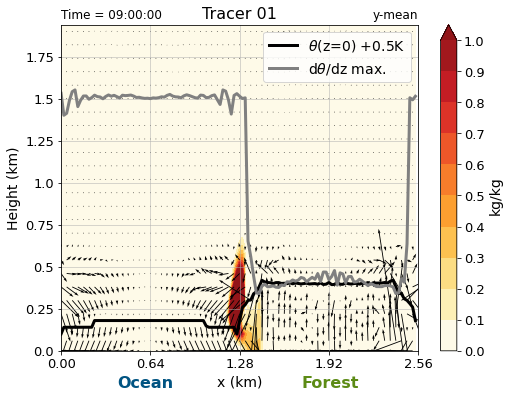

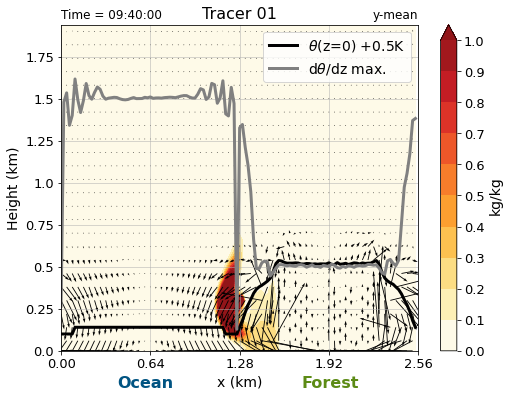

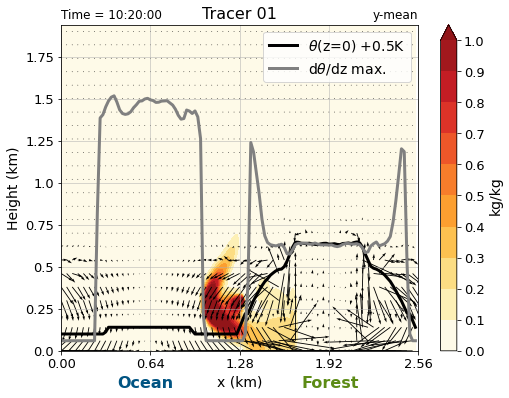

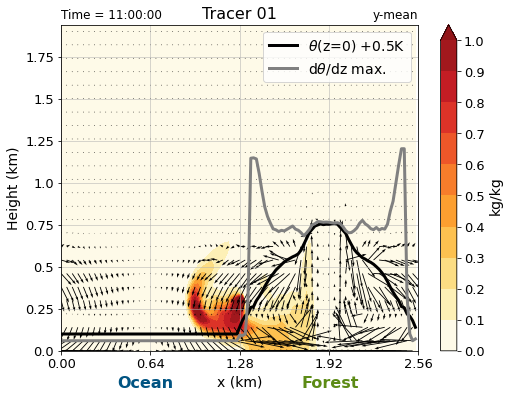

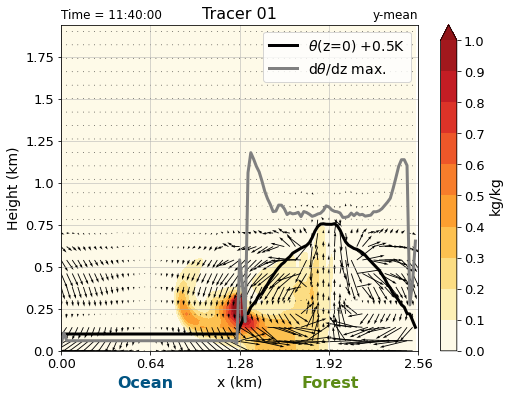

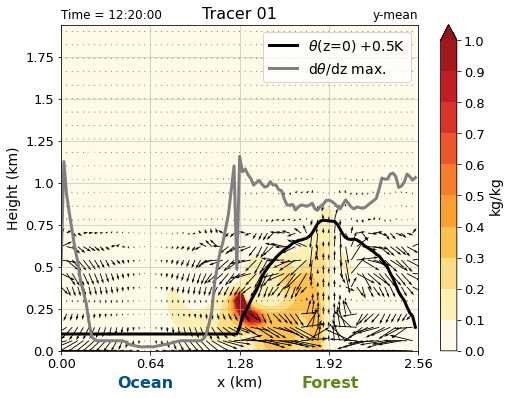

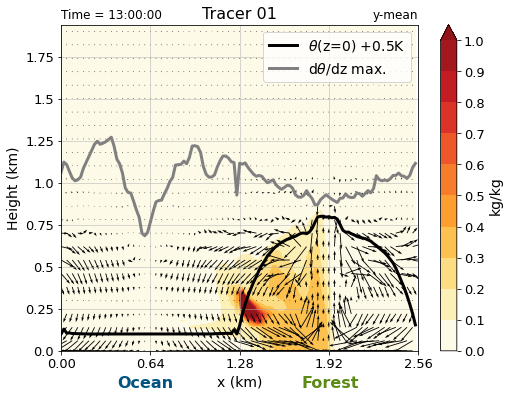

In [80]:
for i in range(0, tr01_cs1.time.shape[0], 20):
    Plot_tr01_ymean(time=i, case='cs1')

### Tracer 02 (Areal Emission)

In [106]:
def Plot_tr02_ymean(time:int, case:str, figpath=False):
    # Case data
    th05   = eval(f'arr_th05_{case}')
    dthdzH = eval(f'arr_dthdzH_{case}')
    tr02   = eval(f'tr02_{case}') 
    tr02_norm = eval(f'tr02_norm_{case}')   # Normalize tracer concentration
    u, w   = eval(f'u_{case}'), eval(f'w_{case}')
    # Figure
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(':', linewidth=0.5)
    x      = np.arange(tr02.lon.shape[0])
    ## Tracer 02
    bounds = np.arange(0, 100.1, 10)
    im     = ax.contourf(x, tr02.lev, tr02.isel(time=time).mean(dim='lat'), 
                         levels=bounds, cmap=cmaps.WhiteYellowOrangeRed, extend='max')
    cbar   = fig.colorbar(im, extend='max')
    cbar.set_ticks(ticks=bounds, labels=[f'{i:3.0f}' for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('kg/kg', fontsize=14)
    ## Wind
    ax.quiver(x[::2], tr02.lev[::2], 
              u.isel(time=time).mean(dim='lat')[::2, ::2], 
              w.isel(time=time).mean(dim='lat')[::2, ::2], angles='xy')
    ## Theta+0.5
    ax.plot(x, th05[time, :], 'k', linewidth=3, label=r'$\theta$(z=0) +0.5K')
    ## max. theta variability
    ax.plot(x, dthdzH[time, :], color='grey', linewidth=3, label=r'd$\theta$/dz max.')
    # Info settings
    ax.text(x=x[20], y=-0.22, s='Ocean', color=c['deep sea blue'], fontsize=16, fontweight='bold')
    ax.text(x=x[86], y=-0.22, s='Forest', color=c['sap green'], fontsize=16, fontweight='bold')
    ax.set_xticks(np.arange(0, x.shape[0]+0.1, 32))
    ax.set_xticklabels([f'{i:4.2f}' for i in np.arange(0, 2.561, 0.64)], fontsize=13)
    ax.set_xlabel('x (km)', fontsize=14)
    ax.set_yticks(np.arange(0, 1.9, 0.25))
    ax.set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax.set_ylabel('Height (km)', fontsize=14)
    ax.legend(loc='upper right', fontsize=14)
    ax.set_title('Tracer 02', fontsize=16)
    ax.set_title('y-mean', loc='right', fontsize=12)
    ax.set_title(f'Time = {(datetime(2024, 1, 1, 5)+timedelta(seconds=120*time)).strftime("%H:%M:%S")}', 
                 loc='left', fontsize=12)
    if figpath:
        plt.savefig(f'./Figure/{figpath}/tr01_ts_{time:03d}.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

/data/mlcloud/miniconda3/envs/weiting3.7/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/data/mlcloud/miniconda3/envs/weiting3.7/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


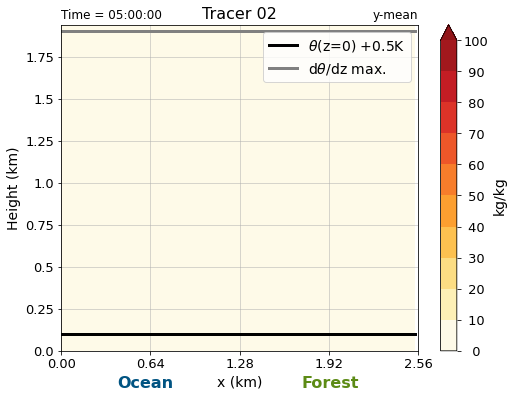

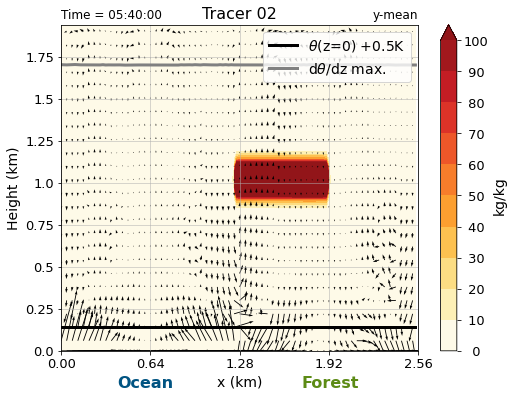

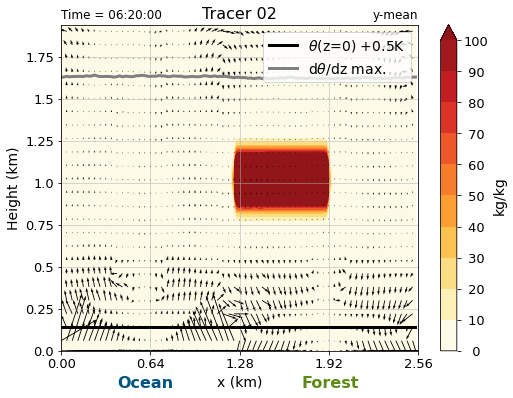

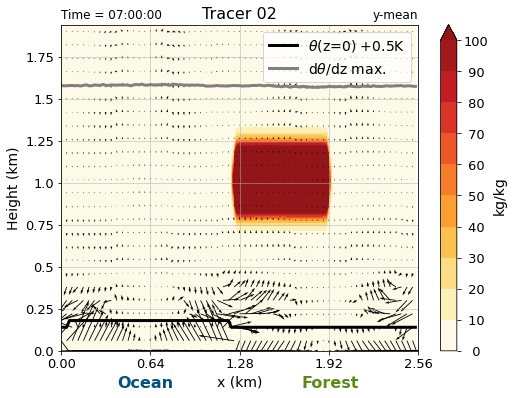

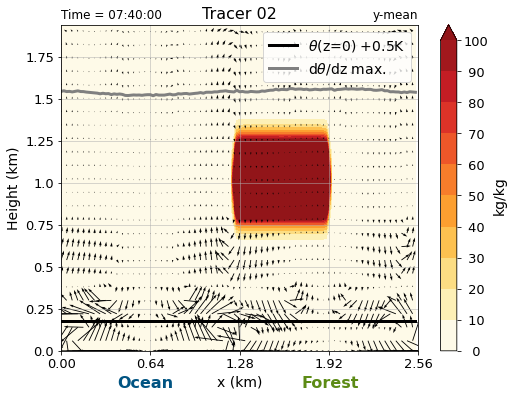

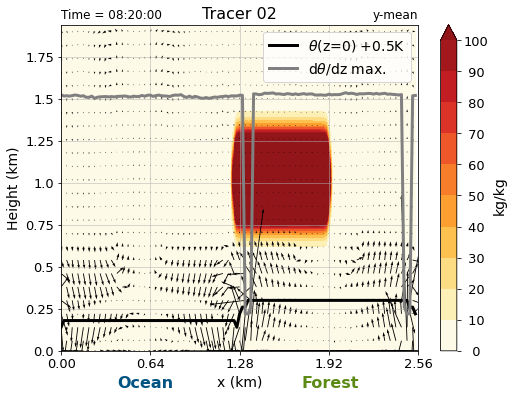

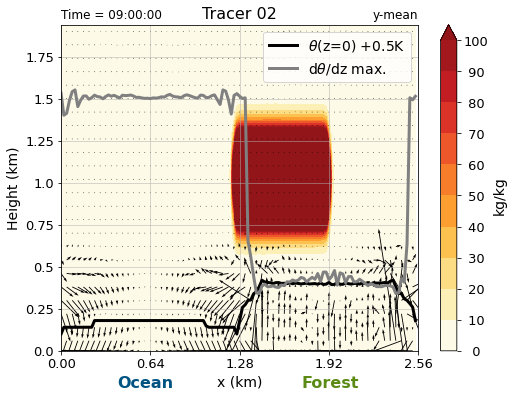

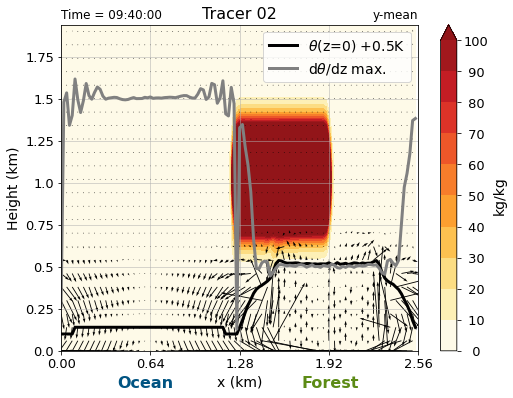

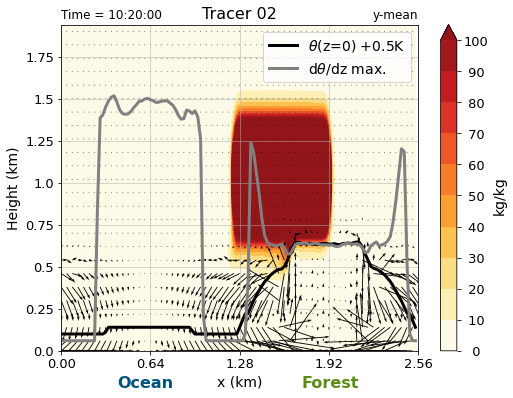

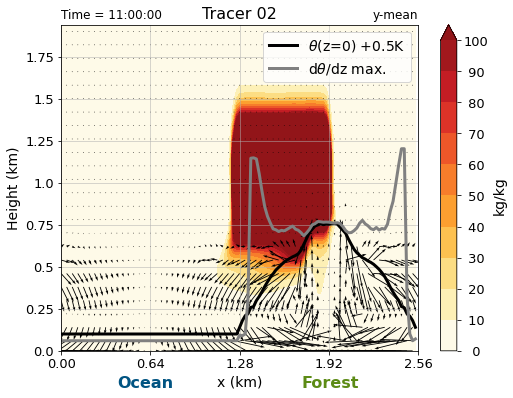

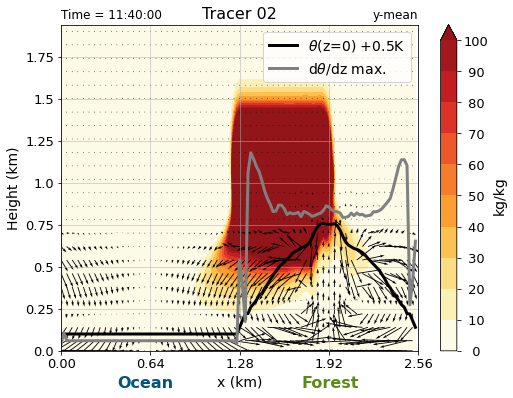

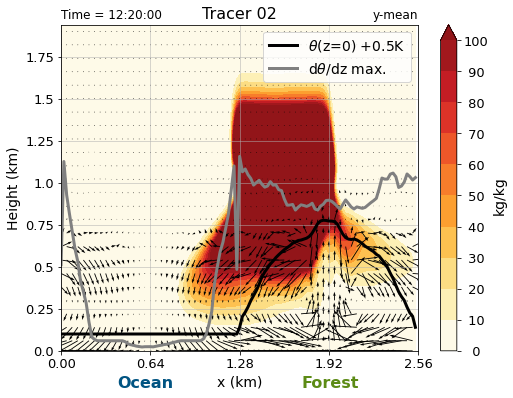

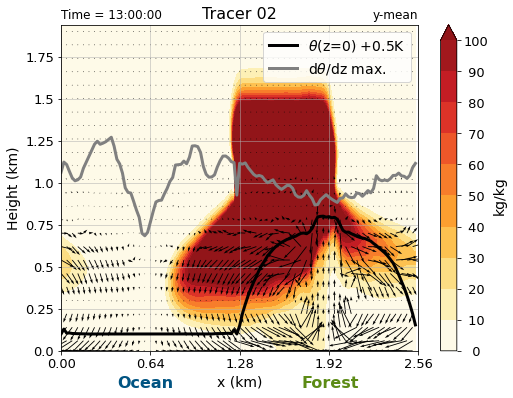

In [107]:
for i in range(0, tr02_cs1.time.shape[0], 20):
    Plot_tr02_ymean(time=i, case='cs1')

In [148]:
for i in range(0, 250, 20):
    Plot_tr02_ymean(time=i, case='cs2')

NameError: name 'arr_th05_cs2' is not defined

### NOx (Areal Emission)

In [145]:
def Plot_nox_dmean(case:str, figpath=False):
    # Case data
    th05   = eval(f'arr_th05_{case}')
    dthdzH = eval(f'arr_dthdzH_{case}')
    NO     = eval(f'NO_{case}') 
    NO2    = eval(f'NO2_{case}')
    NOx    = NO+NO2
    # Figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace':0.05}, sharex=True, sharey=True)
    x      = NOx.time
    ## NOx
    ax[0].grid(':', linewidth=0.5)
    bounds = np.arange(0, 70.1, 5)
    im_ocn = ax[0].contourf(x, NOx.lev, NOx.isel(lon=slice(None, 63)).mean(dim=['lat', 'lon']).T, 
                         levels=bounds, cmap=cmaps.WhiteBlueGreenYellowRed, extend='max')
    cax    = fig.add_axes([ax[1].get_position().x1+0.01, ax[1].get_position().y0, 0.015, ax[1].get_position().height])
    cbar   = fig.colorbar(im_ocn, extend='max', cax=cax)
    cbar.set_ticks(ticks=bounds, labels=[f'{i:3.0f}' for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('ppb', fontsize=14)
    ax[1].grid(':', linewidth=0.5)
    im_frst= ax[1].contourf(x, NOx.lev, NOx.isel(lon=slice(64, None)).mean(dim=['lat', 'lon']).T, 
                         levels=bounds, cmap=cmaps.WhiteBlueGreenYellowRed, extend='max')
    """cbar   = fig.colorbar(im_frst, extend='max')
    cbar.set_ticks(ticks=bounds, labels=[f'{i:3.1f}' for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('ppb', fontsize=14)"""
    ## Theta+0.5
    ax[0].plot(x, np.mean(th05, axis=1), 'k', linewidth=3, label=r'$\theta$(z=0) +0.5K')
    ax[1].plot(x, np.mean(th05, axis=1), 'k', linewidth=3, label=r'$\theta$(z=0) +0.5K')
    ## max. theta variability
    ax[0].plot(x, np.mean(dthdzH, axis=1), color='grey', linewidth=3, label=r'd$\theta$/dz max.')
    ax[1].plot(x, np.mean(dthdzH, axis=1), color='grey', linewidth=3, label=r'd$\theta$/dz max.')
    # Info settings
    #ax.text(x=x[20], y=-0.22, s='Ocean', color=c['deep sea blue'], fontsize=16, fontweight='bold')
    #ax.text(x=x[86], y=-0.22, s='Forest', color=c['sap green'], fontsize=16, fontweight='bold')
    ax[0].set_xticks(NOx.time[::90])
    ax[0].set_xticklabels([f'{NOx.time.dt.hour[i]+5:02d}:{NOx.time.dt.minute[i]:02d}' for i in range(0, NOx.shape[0], 90)], 
                       fontsize=13)
    ax[0].set_xlabel('Local time', fontsize=14)
    ax[0].set_xlabel('x (km)', fontsize=14)
    ax[1].set_xticks(NOx.time[::90])
    ax[1].set_xticklabels([f'{NOx.time.dt.hour[i]+5:02d}:{NOx.time.dt.minute[i]:02d}' for i in range(0, NOx.shape[0], 90)], 
                       fontsize=13)
    ax[1].set_xlabel('Local time', fontsize=14)
    ax[1].set_xlabel('x (km)', fontsize=14)
    ax[0].set_yticks(np.arange(0, 1.9, 0.25))
    ax[0].set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax[0].set_ylabel('Height (km)', fontsize=14)
    ax[0].legend(loc='upper right', fontsize=14)
    ax[0].set_title('Ocean Mean', fontsize=16)
    ax[1].set_title('Forest Mean', fontsize=16)
    ax[1].set_title('NOx', fontsize=16, loc='right')
    """ax.set_title('y-mean', loc='right', fontsize=12)
    ax.set_title(f'Time = {(datetime(2024, 1, 1, 5)+timedelta(seconds=120*time)).strftime("%H:%M:%S")}', 
                 loc='left', fontsize=12)"""
    if figpath:
        plt.savefig(f'./Figure/{figpath}/{case}.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

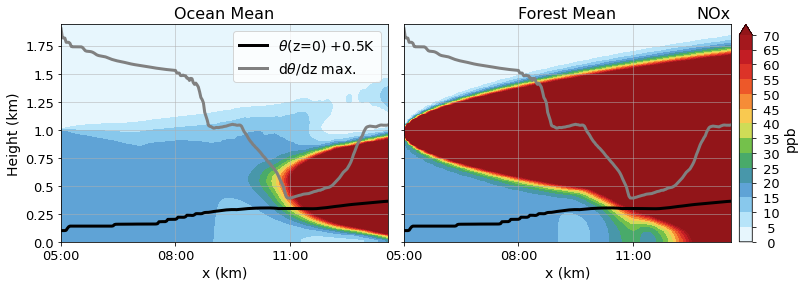

In [147]:
Plot_nox_dmean(case='cs1', figpath='hw5_nox_hovmoeller')

In [116]:
NO_cs1.isel(lon=slice(None, 63)).mean(dim=['lat', 'lon']).T

<xarray.DataArray 'NO' (lev: 50, time: 258)>
dask.array<transpose, shape=(50, 258), dtype=float32, chunksize=(50, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 ... 1900-01-01T08:34:00
  * lev      (lev) float64 0.0 0.02 0.06 0.1 0.14 ... 1.78 1.82 1.86 1.9 1.94